In [1]:
import numpy as np
def seqTrans(argument):
    switcher = {
        'A': 0.25,
        'T': 0.5,
        'G': 0.75,
        'C': 1.0,
        'N': np.random.randint(1,4)
    }
    return switcher.get(argument, "Invalid month")

def lineToArr(line):
    arr = np.array([])
    for a in line:
        v = seqTrans(a)    
        arr = np.append(arr,v)    
    return arr


import csv

l_arr = []
y =np.array([])
with open('NGS201811_Censored(updated).csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            #print row
            line_count += 1
        else:            
            line_count += 1
            l_arr.append(lineToArr(row[0]))
            y = np.append(y,row[2])
            
m_data = np.asmatrix(l_arr)
y = y.astype('float32')
m_data = m_data.astype('float32')
#m_data = np.expand_dims(m_data, axis=2)
#m_data=m_data.transpose()
#y = y.reshape(1,len(y))
print y.shape, m_data.shape

(171427,) (171427, 33)


[128522.  42905.]


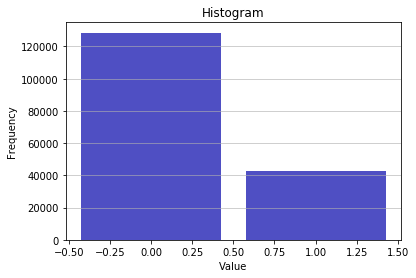

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline  
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=y, bins=[-0.5,0.5,1.5], color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
#plt.text(23, 45, r'$\mu=15, b=3$')
print n
maxfreq = n.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [3]:
train_ratio = 0.8
idx = np.random.randint(len(y), size=int(len(y)*train_ratio))
x_train = m_data[idx,]
y_train = y[idx,]
print x_train.shape,y_train.shape

(137141, 33) (137141,)


In [4]:
from keras.utils import to_categorical
num_classes = 2
y_binary = to_categorical(y_train,num_classes)

Using TensorFlow backend.


In [5]:
y_t = np.expand_dims(y_train,axis=1)
print y_t.shape

(137141, 1)


In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils
num_sensors = 1
TIME_PERIODS = 33
input_shape = 33
num_classes = 2

model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 5, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 5, activation='relu'))
model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(100, 3, activation='relu'))
model_m.add(Conv1D(100, 3, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 33, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 29, 100)           600       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 100)           50100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 100)           30100     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 8, 100)            30100     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
__________

In [7]:
print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 200
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_binary,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)


--- Fit the model ---

Train on 109712 samples, validate on 27429 samples
Epoch 1/50
109712/109712 [==============================] - 19s 171us/step - loss: 0.5155 - acc: 0.7780 - val_loss: 0.4458 - val_acc: 0.8161
Epoch 2/50
109712/109712 [==============================] - 18s 164us/step - loss: 0.4330 - acc: 0.8190 - val_loss: 0.4028 - val_acc: 0.8336
Epoch 3/50
109712/109712 [==============================] - 17s 159us/step - loss: 0.3976 - acc: 0.8318 - val_loss: 0.3713 - val_acc: 0.8427
Epoch 4/50
109712/109712 [==============================] - 17s 159us/step - loss: 0.3647 - acc: 0.8462 - val_loss: 0.3632 - val_acc: 0.8456
Epoch 5/50
109712/109712 [==============================] - 18s 161us/step - loss: 0.3391 - acc: 0.8578 - val_loss: 0.3349 - val_acc: 0.8589
Epoch 6/50
109712/109712 [==============================] - 17s 159us/step - loss: 0.3223 - acc: 0.8651 - val_loss: 0.3266 - val_acc: 0.8607
Epoch 7/50
109712/109712 [==============================] - 17s 159us/step - lo

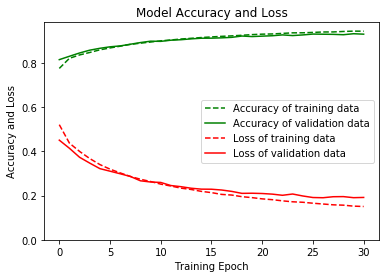

In [8]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [9]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


--- Check against test data ---

(76884, 33) (76884,)
76884/76884 [==============================] - 7s 87us/step

Accuracy on test data: 0.92

Loss on test data: 0.22

--- Confusion matrix for test data ---



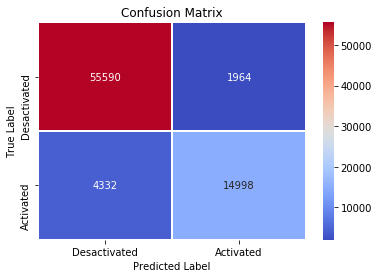


--- Classification report for test data ---

             precision    recall  f1-score   support

          0       0.93      0.97      0.95     57554
          1       0.88      0.78      0.83     19330

avg / total       0.92      0.92      0.92     76884



In [10]:
#%%
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns
from scipy import stats
LABELS = ["Desactivated",
          "Activated"]

print("\n--- Check against test data ---\n")
x_test=np.delete(m_data,idx,axis=0)
y_test=np.delete(y,idx)
print x_test.shape, y_test.shape

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

# %%

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

# %%

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))